## Sim0 experiments

Take some random data that have similar feature/target shapes as real data. 

The target is just one of the inputs combined with some of the known future information

The last feature in the input shows which of the other features are produced at the output.
For a time length $n$, $f+1$ features, $k < f$ indicator variable, the $f$'th feature will have the portion $\left \lfloor k*(n/f) \right \rfloor - \left \lfloor (k+1)*(n/f) \right \rfloor$ biased with a positive value.

In [1]:
# %matplotlib widget # Uncomment this to get interactive graphics
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from fastai2.vision.all import *
import torch
import network_definitions
import seaborn as sns

In [2]:
# We define the data generator.
def gen_data(past_length, future_length, feature_count=14, label=None):
    # The data shape is F, S, where F is the number of features, S is the time length (past_length). T is future_length
    # What of the F-1 features will be outputted?
    if label is None:
        label = np.random.randint(features-1)
    # Generate a bunch of random data
    features = np.random.rand(feature_count, past_length) 
    # This will encode the indicator feature
    label_enc = np.zeros(past_length)
    label_len = min(int(past_length/feature_count), 10)
    label_pos = label * label_len
    label_enc[label_pos:(label_pos+label_len)] = 2
    # We add the label encoding to the last feature. We allow some noise
    features[-1, :] = features[-1, :] * 0.1 + label_enc * 0.8
    # Some known future, again, random
    x2 = np.random.rand(future_length)
    # The target is the linear combination between some past data and known future
    output = features[label, 0:future_length] * 0.5 + x2 * 0.5
    return features, x2, output

X1 shape: (4, 30), X2 shape: (10,)
Data label: 1


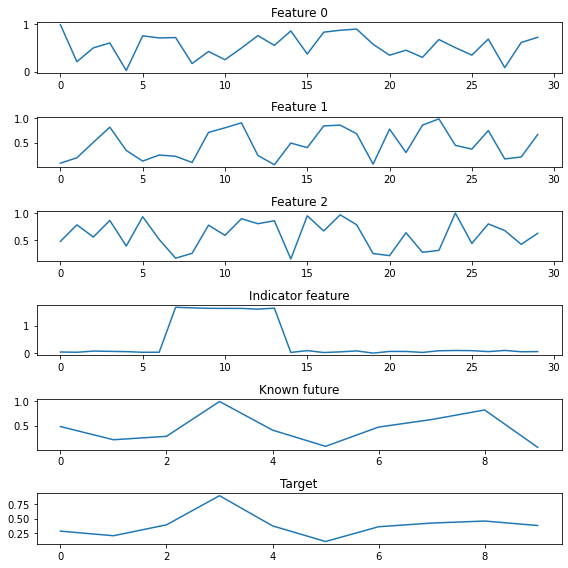

In [3]:
# Let's see some plots.
label=1
x1, x2, y = gen_data(30, 10, feature_count=4, label=label)
fig, ax = plt.subplots(6,1,figsize=(8, 8))
ax[0].plot(x1[0, :])
ax[0].set_title("Feature 0")
ax[1].plot(x1[1, :])
ax[1].set_title("Feature 1")
ax[2].plot(x1[2, :])
ax[2].set_title("Feature 2")
ax[3].plot(x1[3, :])
ax[3].set_title("Indicator feature")
ax[4].plot(x2)
ax[4].set_title("Known future")
ax[5].plot(y)
ax[5].set_title("Target")
print(f"X1 shape: {x1.shape}, X2 shape: {x2.shape}\nData label: {label}")
fig.tight_layout()

In [4]:
# Custom made data itemizer

class Sim0Itemizer(ItemTransform):
    def __init__(self, transformer=False):
        super().__init__()
        self.transformer = transformer

    def encodes(self, input):
        x1, x2, output = input
        if self.transformer:
            out_shift = np.zeros(x2.shape[0])
            out_shift[1:] = output[0:-1]
            x2 = np.vstack([x2, out_shift])
        x1 = tensor(x1).float()
        x2 = tensor(x2).float()
        y = tensor(output).float()
        return (x1, x2), y
    
past_length = 30
no_features = 4
future_length = 10
N = 1000
batch_size = 64
train_labels = np.random.randint(0, no_features - 1, size=N)
val_labels = np.random.randint(0, no_features - 1, size=N)

train_set = [gen_data(past_length, future_length, no_features, l) for l in train_labels]
val_set = [gen_data(past_length, future_length, no_features, l) for l in val_labels]

data_itemizer = Sim0Itemizer()
tls_train = TfmdLists(train_set, data_itemizer)
tls_valid = TfmdLists(val_set, data_itemizer)
dloader = DataLoaders.from_dsets(tls_train, tls_valid, bs=batch_size).cuda()

data_itemizerT = Sim0Itemizer(transformer=True)
tls_trainT = TfmdLists(train_set, data_itemizerT)
tls_validT = TfmdLists(val_set, data_itemizerT)
dloaderT = DataLoaders.from_dsets(tls_trainT, tls_validT, bs=batch_size).cuda()


## Training loops
We train each model independently so we can "tune" if necessary

In [5]:
callbacks = [ReduceLROnPlateau(patience=5, factor=2),
             EarlyStoppingCallback(patience=15),
             SaveModelCallback(fname="best_model")]

epoch,train_loss,valid_loss,time
0,0.535646,0.265568,00:00
1,0.361708,0.095955,00:00
2,0.234775,0.046549,00:00
3,0.160208,0.034767,00:00
4,0.116186,0.031728,00:00
5,0.088167,0.030559,00:00
6,0.069445,0.029589,00:00
7,0.056535,0.029234,00:00
8,0.047339,0.028963,00:00
9,0.040807,0.028914,00:00


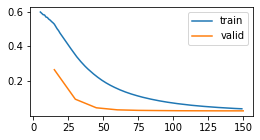

In [6]:
model_Linear= network_definitions.LinearModel(in_features=no_features, past_steps=past_length, future_steps=future_length).cuda()
learner_Linear = Learner(dloader, model_Linear, loss_func=MSELossFlat())
# print(learner_Linear.summary())
# learner_Linear.lr_find()
learner_Linear.fit_one_cycle(10, 5e-3, cbs=callbacks)
fig = plt.figure(figsize=(4, 2))  # because jupyter widgets always changing semantics.
learner_Linear.recorder.plot_loss()

epoch,train_loss,valid_loss,time
0,0.098416,0.059371,00:00
1,0.065695,0.042096,00:00
2,0.049289,0.036975,00:00
3,0.040335,0.032148,00:00
4,0.033291,0.029030,00:00
5,0.027996,0.025158,00:00
6,0.023600,0.027913,00:00
7,0.019612,0.023628,00:00
8,0.016238,0.022920,00:00
9,0.013605,0.022612,00:00


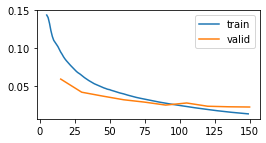

In [7]:
model_Cnn= network_definitions.CnnFcn(in_features=no_features, past_steps=past_length, future_steps=future_length, cnn_stack_len=1,
                                fcn_stack_len=1, cnn_filters=64, avg_pool_len=10, fcn_ratio=0.8).cuda()
learner_Cnn = Learner(dloader, model_Cnn, loss_func=MSELossFlat())
# print(learner_Cnn.summary())
# learner_Cnn.lr_find()
learner_Cnn.fit_one_cycle(10, 5e-3, cbs=callbacks)
fig = plt.figure(figsize=(4, 2))
learner_Cnn.recorder.plot_loss()

epoch,train_loss,valid_loss,time
0,0.208491,0.042197,00:00
1,0.119108,0.046241,00:00
2,0.084481,0.037771,00:00
3,0.066354,0.033327,00:00
4,0.053977,0.024923,00:00
5,0.044516,0.021675,00:00
6,0.038050,0.021596,00:00
7,0.033512,0.021584,00:00
8,0.030396,0.021552,00:00
9,0.028174,0.021550,00:00


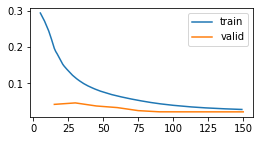

In [8]:
model_EncDec= network_definitions.EncoderDecoder(in_features=no_features, past_steps=past_length, future_steps=future_length, 
                                                hidden_size=128, num_layers=2).cuda()
learner_EncDec = Learner(dloader, model_EncDec, loss_func=MSELossFlat())
# print(learner_EncDec.summary())
# learner_EncDec.lr_find()
learner_EncDec.fit_one_cycle(10, 5e-3, cbs=callbacks)
fig = plt.figure(figsize=(4, 2))
learner_EncDec.recorder.plot_loss()

epoch,train_loss,valid_loss,time
0,0.245349,0.224248,00:01
1,0.216663,0.157162,00:01
2,0.172221,0.072028,00:01
3,0.133367,0.068464,00:01
4,0.106498,0.046049,00:01
5,0.086875,0.043227,00:01
6,0.073540,0.041902,00:01
7,0.064381,0.041548,00:01
8,0.058059,0.041414,00:01
9,0.053529,0.041358,00:01


Epoch 31: reducing lr to 4.2011303870782786e-05
Epoch 36: reducing lr to 6.392932406566862e-06


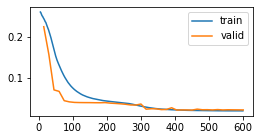

In [9]:
model_Att= network_definitions.AttentionModel(in_features=no_features, past_steps=past_length, future_steps=future_length, 
                                                hidden_size=128, num_layers=2).cuda()
learner_Att = Learner(dloader, model_Att, loss_func=MSELossFlat())
# print(learner_Att.summary())
# learner_Att.lr_find()
learner_Att.fit_one_cycle(40, 5e-4, cbs=callbacks)
fig = plt.figure(figsize=(4, 2))
learner_Att.recorder.plot_loss()

epoch,train_loss,valid_loss,time
0,0.356917,0.319797,00:01
1,0.279060,0.055147,00:01
2,0.201893,0.030667,00:01
3,0.154060,0.026993,00:01
4,0.123118,0.023101,00:01
5,0.101894,0.023144,00:01
6,0.086278,0.024871,00:01
7,0.074531,0.024848,00:01
8,0.065953,0.023411,00:01
9,0.059407,0.023005,00:01


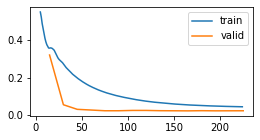

In [10]:
model_TransS= network_definitions.SimpleTransformer(in_features=no_features, past_steps=past_length, future_steps=future_length, 
                                                d_model=128, dim_feedforward=512).cuda()
learner_TransS = Learner(dloader, model_TransS, loss_func=MSELossFlat())
# print(learner_TransS.summary())
# learner_TransS.lr_find()
learner_TransS.fit_one_cycle(15, 1e-4, cbs=callbacks)
fig = plt.figure(figsize=(4, 2))
learner_TransS.recorder.plot_loss()

epoch,train_loss,valid_loss,time
0,0.488940,0.291826,00:02
1,0.339768,0.292127,00:02
2,0.233707,0.077832,00:02
3,0.170109,0.075776,00:02
4,0.130839,0.076345,00:02
5,0.105246,0.066717,00:02
6,0.087535,0.063908,00:02
7,0.074916,0.060117,00:02
8,0.065634,0.057210,00:02
9,0.058674,0.059035,00:02


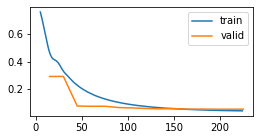

In [11]:
model_TransF= network_definitions.TransformerFull(in_features=no_features, past_steps=past_length, future_steps=future_length, 
                                                  target_features=2, d_model=128, dim_feedforward=512).cuda()
learner_TransF = Learner(dloaderT, model_TransF, loss_func=MSELossFlat())
# print(learner_TransF.summary())
# learner_TransF.lr_find()
learner_TransF.fit_one_cycle(15, 1e-4, cbs=callbacks)
fig = plt.figure(figsize=(4, 2))
learner_TransF.recorder.plot_loss()

## Let's view some results!

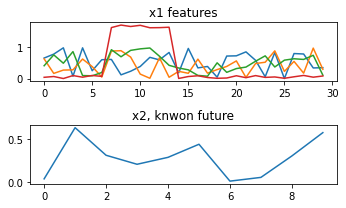

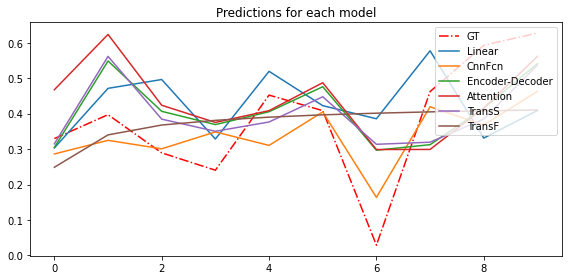

In [12]:
def get_lerner_prediction(learner, sample, label):
    decoded_output, _, _ = learner.predict(sample, with_input=False)
    return (decoded_output.numpy(), label)

item = val_set[556]

predictions =[
    get_lerner_prediction(learner_Linear, item, "Linear"),
    get_lerner_prediction(learner_Cnn, item, "CnnFcn"),
    get_lerner_prediction(learner_EncDec, item, "Encoder-Decoder"),
    get_lerner_prediction(learner_Att, item, "Attention"),
    get_lerner_prediction(learner_TransS, item, "TransS"),
    get_lerner_prediction(learner_TransF, item, "TransF"),
]

fig, ax = plt.subplots(2, 1, figsize=(5, 3))
ax[0].plot(item[0].T)
ax[0].set_title("x1 features")
ax[1].plot(item[1])
ax[1].set_title("x2, knwon future")
fig.tight_layout()
fig, ax = plt.subplots(1, 1, figsize=(8, 4));ax=[ax]
ax[0].plot(item[2], 'r-.', label="GT",)
for preds in predictions:
    ax[0].plot(preds[0], label=preds[1])
ax[0].legend(loc='upper right')
ax[0].set_title("Predictions for each model")
fig.tight_layout()
